# The Goal
- Improve neural network performance with hyperparameter tuning targeted at reducing overfitting. (neural architecture, gradient descent batch size, regularization)
- Create functions to make training/testing pipeline more efficient
- Utilize Grid Search if educated guesses make no progress.

# Step 1: Reproduce SMOTE training set
(conditions of last best result)

In [48]:
import tensorflow as tf
import sklearn
import numpy as np
from numpy import where
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import TensorBoard
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, PredefinedSplit, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score, auc, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import collections
from collections import Counter
import logging
import os
import sys
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [86]:
df = pd.read_csv('./creditcard.csv')
X = df.drop('Class', axis=1).values
Y = df.Class.values

seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

x, x_test, y, y_test = train_test_split(X, Y, test_size=0.15, shuffle=True, random_state=seed)
x_train, x_cv, y_train, y_cv = train_test_split(x, y, test_size=0.15, shuffle=True, random_state=seed)

# applying SMOTE
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

## Step 2: Hyperparameter tuning cycle on NN

In [44]:
## NN

def create_nn_model(hiddenlyrs=8, num_hiddenlyrs=1, l=0, act='relu', input_shape=0, learning_rate=0.01):
    seed=1234
    tf.random.set_seed(seed)
    np.random.seed(seed)

    model = tf.keras.Sequential()

    if input_shape != 0:
        model.add(tf.keras.Input(input_shape, )) # adding input layer

    for i in range(0, num_hiddenlyrs):
        model.add(Dense(hiddenlyrs, activation=act, kernel_regularizer=tf.keras.regularizers.l2(l=l)))

    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(l=l))) # adding output layer

    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model


In [33]:
# create model
nn_model = KerasClassifier(build_fn=create_nn_model, verbose=0)

# define the grid search parameters
l = [0.1, 0.05, 0.01]
input_shape = [x_train_smote.shape[1]]
hiddenlyrs = [128] # 1 hidden layer, 128 nodes
num_hiddenlyrs = [1]
batch_size=[100]
param_grid = dict(l=l, input_shape=input_shape, num_hiddenlyrs=num_hiddenlyrs, hiddenlyrs=hiddenlyrs, batch_size=batch_size)

# generating predefined cv
x_grid = np.append(x_train_smote, x_cv, axis=0)
y_grid = np.append(y_train_smote, y_cv, axis=0)
train_indices = np.full((x_train_smote.shape[0]), -1, dtype=int)
cv_indices = np.full((x_cv.shape[0]), 0, dtype=int)
test_fold = np.append(train_indices, cv_indices)
ps = PredefinedSplit(test_fold)

In [34]:
scoring = {"AUC":"roc_auc", "Precision":"precision", "Recall":"recall"}
grid = GridSearchCV(
    estimator=nn_model,
    param_grid=param_grid,
    cv=ps,
    scoring=scoring,
    refit="AUC",
    verbose=2,
)

nn_grid = grid.fit(x_grid, y_grid)
nn_grid_results = nn_grid.cv_results_


Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV] END batch_size=100, hiddenlyrs=128, input_shape=30, l=0.1, num_hiddenlyrs=1; total time=  16.1s
[CV] END batch_size=100, hiddenlyrs=128, input_shape=30, l=0.05, num_hiddenlyrs=1; total time=  15.8s
[CV] END batch_size=100, hiddenlyrs=128, input_shape=30, l=0.01, num_hiddenlyrs=1; total time=  14.3s


In [38]:
display(nn_grid_results.keys())
display(nn_grid_results['params'])


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_batch_size', 'param_hiddenlyrs', 'param_input_shape', 'param_l', 'param_num_hiddenlyrs', 'params', 'split0_test_AUC', 'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC', 'split0_test_Precision', 'mean_test_Precision', 'std_test_Precision', 'rank_test_Precision', 'split0_test_Recall', 'mean_test_Recall', 'std_test_Recall', 'rank_test_Recall'])

[{'batch_size': 100,
  'hiddenlyrs': 128,
  'input_shape': 30,
  'l': 0.1,
  'num_hiddenlyrs': 1},
 {'batch_size': 100,
  'hiddenlyrs': 128,
  'input_shape': 30,
  'l': 0.05,
  'num_hiddenlyrs': 1},
 {'batch_size': 100,
  'hiddenlyrs': 128,
  'input_shape': 30,
  'l': 0.01,
  'num_hiddenlyrs': 1}]

In [41]:
df1= pd.DataFrame(index=l, columns=['AUC', 'Precision', "Recall", 'f1'])
df1['AUC'] = nn_grid_results['mean_test_AUC']
df1['Precision'] = nn_grid_results['mean_test_Precision']
df1['Recall'] = nn_grid_results['mean_test_Recall']
df1['f1'] = 2 * nn_grid_results['mean_test_Recall'] * nn_grid_results['mean_test_Precision'] / (nn_grid_results['mean_test_Precision'] + nn_grid_results['mean_test_Recall'])


In [43]:
display(df1)

,AUC,Precision,Recall,f1
0.10,0.836495,0.001296,0.979167,0.002589
0.05,0.775678,0.001378,0.979167,0.002752
0.01,0.957479,0.002534,0.958333,0.005054


The new, larger neural architecture with mini batch gradient descent seems to be performing much better. Perfoming treshold tuning to get f1 score for optimal threshold, using params {'batch_size': 100,
  'hiddenlyrs': 128,
  'input_shape': 30,
  'l': 0.01,
  'num_hiddenlyrs': 1}

In [45]:

NOW = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
NAME = f"creditcard_fraud_lgmodel_{NOW}"
tensorboard = TensorBoard(log_dir=f'./logs/{NAME}', histogram_freq=1)

m = create_nn_model(hiddenlyrs=128, num_hiddenlyrs=1, l=0.01, act='relu', input_shape=x_train_smote.shape[1], learning_rate=0.01)
m.fit(
    x_train_smote, y_train_smote,
    epochs=10,
    callbacks = [tensorboard],
    validation_data = (x_cv, y_cv),
    batch_size=100
)

Train on 410818 samples, validate on 36313 samples
Epoch 1/10
410818/410818 [==============================] - 28s 69us/sample - loss: 75.6040 - auc_10: 0.7262 - precision_10: 0.7093 - recall_10: 0.7299 - val_loss: 1.5329 - val_auc_10: 0.9532 - val_precision_10: 0.0025 - val_recall_10: 0.9583
Epoch 2/10
410818/410818 [==============================] - 20s 48us/sample - loss: 0.7870 - auc_10: 0.8017 - precision_10: 0.7548 - recall_10: 0.6670 - val_loss: 0.6911 - val_auc_10: 0.4964 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 3/10
410818/410818 [==============================] - 14s 35us/sample - loss: 0.6939 - auc_10: 0.5034 - precision_10: 0.5016 - recall_10: 0.5584 - val_loss: 0.6840 - val_auc_10: 0.5010 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 4/10
410818/410818 [==============================] - 14s 35us/sample - loss: 0.6983 - auc_10: 0.5014 - precision_10: 0.5007 - recall_10: 0.5225 - val_loss: 0.7105 - val_auc_10: 0.5014 - val_precision

In [47]:
%load_ext tensorboard
%tensorboard --logdir logs/{NAME}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 7400), started 0:00:02 ago. (Use '!kill 7400' to kill it.)

'optimal threshold: 0.513211190700531'

              precision    recall  f1-score   support

           0       1.00      0.00      0.00     36265
           1       0.00      1.00      0.00        48

    accuracy                           0.00     36313
   macro avg       0.50      0.50      0.00     36313
weighted avg       1.00      0.00      0.00     36313



'macro avg f1 score 0.84, improvement from 0.005054 (results without hyperparameter tuning)'

'roc auc score: 0.5009237556873019'

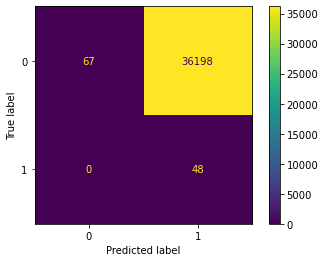

In [57]:
preds = m.predict_proba(x_cv)
fpr, tpr, thresholds = roc_curve(y_cv, preds)
opt_index = np.argmax(tpr-fpr)
opt_threshold = thresholds[opt_index]
display(f'optimal threshold: {opt_threshold}')

pred_class = list((preds >= opt_threshold).astype(int))
pred_class = list(map(lambda x: x[0], pred_class))

cm = confusion_matrix(y_cv, pred_class)
dp1 = ConfusionMatrixDisplay(confusion_matrix=cm)
dp1.plot()
print(classification_report(y_cv, pred_class))
display('macro avg f1 score 0.00, no improvement from 0.005054 (results without hyperparameter tuning)')
display(f'roc auc score: {roc_auc_score(y_cv, pred_class)}')


Even with optimal threshold, NN performance isn't great, seems to be overfitting to the positive examples in the SMOTE oversampled training set. Reattempting training with same neural architecture, but with a training set with stratified splitting instead of SMOTE oversampling.

In [103]:
# generating stratified split training set
seed=1234
tf.random.set_seed(seed)
np.random.seed(seed)
X = df.drop('Class', axis=1).values
Y = df.Class.values
x, x_test, y, y_test = train_test_split(X, Y, test_size=0.15, shuffle=True, random_state=seed, stratify=Y)
x_train_strat, x_cv_strat, y_train_strat, y_cv_strat = train_test_split(x, y, test_size=0.15, shuffle=True, random_state=seed, stratify=y)

In [83]:
model = Sequential() 
model.add(Dense(128, activation='relu', input_dim=30))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 129       
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [104]:
hist = model.fit(x_train_strat, y_train_strat, validation_data=(x_cv, y_cv), epochs=10, batch_size=100)

Train on 205772 samples, validate on 36313 samples
Epoch 1/10
205772/205772 [==============================] - 6s 28us/sample - loss: 6.7199 - accuracy: 0.9962 - val_loss: 24.2027 - val_accuracy: 0.9986
Epoch 2/10
205772/205772 [==============================] - 5s 26us/sample - loss: 9.9271 - accuracy: 0.9967 - val_loss: 15.0771 - val_accuracy: 0.9987
Epoch 3/10
205772/205772 [==============================] - 5s 26us/sample - loss: 5.8700 - accuracy: 0.9967 - val_loss: 17.8612 - val_accuracy: 0.9987
Epoch 4/10
205772/205772 [==============================] - 5s 26us/sample - loss: 6.9532 - accuracy: 0.9967 - val_loss: 16.3142 - val_accuracy: 0.9987
Epoch 5/10
205772/205772 [==============================] - 5s 26us/sample - loss: 7.9683 - accuracy: 0.9970 - val_loss: 0.5013 - val_accuracy: 0.9988
Epoch 6/10
205772/205772 [==============================] - 5s 25us/sample - loss: 5.2855 - accuracy: 0.9966 - val_loss: 6.5439 - val_accuracy: 0.9988
Epoch 7/10
205772/205772 [=============

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36265
           1       0.47      0.77      0.59        48

    accuracy                           1.00     36313
   macro avg       0.74      0.88      0.79     36313
weighted avg       1.00      1.00      1.00     36313



'macro avg f1 score 0.79, large improvement from 0.005054 (results on SMOTE oversampling dataset without hyperparameter tuning)'

'roc auc score: 0.8848513833356313'

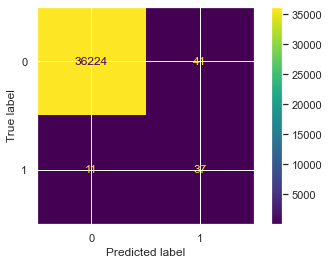

In [110]:
y_predicted = model.predict(x_cv) > 0.5 # testing on original cv set for valid comparison to previous models
cm = confusion_matrix(y_cv, y_predicted)
dp1 = ConfusionMatrixDisplay(confusion_matrix=cm)
dp1.plot()
print(classification_report(y_cv, y_predicted))
display('macro avg f1 score 0.79, large improvement from 0.005054 (results on SMOTE oversampling dataset without hyperparameter tuning)')
display(f'roc auc score: {roc_auc_score(y_cv, y_predicted)}')


[]

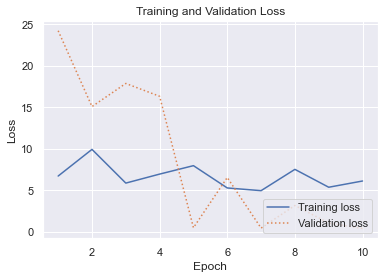

In [111]:
sns.set()
 
acc = hist.history['loss']
val = hist.history['val_loss']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training loss')
plt.plot(epochs, val, ':', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.plot()

With new stratified training set, tune neural architecture

In [153]:
model1 = Sequential() 
model1.add(Dense(128, activation='relu', input_dim=30))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='sigmoid')) 
model1.compile(loss='binary_crossentropy', optimizer='adam',
    metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
) 
model1.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_185 (Dense)            (None, 128)               3968      
_________________________________________________________________
dense_186 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_187 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_188 (Dense)            (None, 1)                 129       
Total params: 37,121
Trainable params: 37,121
Non-trainable params: 0
_________________________________________________________________


In [154]:
hist1 = model1.fit(x_train_strat, y_train_strat, validation_data=(x_cv, y_cv), epochs=10, batch_size=100)

Train on 205772 samples, validate on 36313 samples
Epoch 1/10
205772/205772 [==============================] - 15s 74us/sample - loss: 36.8202 - auc_38: 0.5050 - precision_38: 0.0047 - recall_38: 0.0169 - val_loss: 18.3821 - val_auc_38: 0.4999 - val_precision_38: 0.0000e+00 - val_recall_38: 0.0000e+00
Epoch 2/10
205772/205772 [==============================] - 14s 66us/sample - loss: 89.4839 - auc_38: 0.5079 - precision_38: 0.0090 - recall_38: 0.0197 - val_loss: 94.5747 - val_auc_38: 0.5000 - val_precision_38: 0.0000e+00 - val_recall_38: 0.0000e+00
Epoch 3/10
205772/205772 [==============================] - 14s 67us/sample - loss: 58.3768 - auc_38: 0.5082 - precision_38: 0.0105 - recall_38: 0.0197 - val_loss: 14.8196 - val_auc_38: 0.4999 - val_precision_38: 0.0000e+00 - val_recall_38: 0.0000e+00
Epoch 4/10
205772/205772 [==============================] - 14s 66us/sample - loss: 27.4448 - auc_38: 0.5001 - precision_38: 0.0020 - recall_38: 0.0056 - val_loss: 3.5175 - val_auc_38: 0.5102 -

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36265
           1       1.00      0.04      0.08        48

    accuracy                           1.00     36313
   macro avg       1.00      0.52      0.54     36313
weighted avg       1.00      1.00      1.00     36313



'roc auc score: 0.5208333333333334'

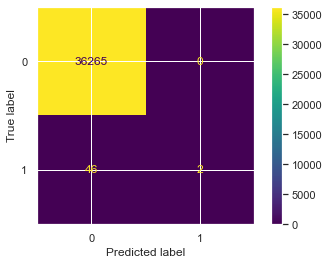

In [156]:
y_predicted = model1.predict(x_cv) > 0.5 # testing on original cv set for valid comparison to previous models
cm = confusion_matrix(y_cv, y_predicted)
dp1 = ConfusionMatrixDisplay(confusion_matrix=cm)
dp1.plot()
print(classification_report(y_cv, y_predicted))
display(f'roc auc score: {roc_auc_score(y_cv, y_predicted)}')


[]

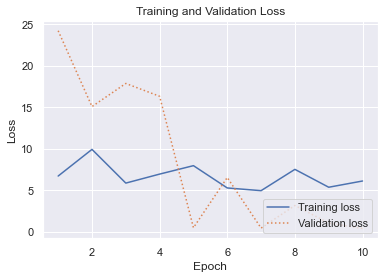

In [141]:
sns.set()
 
acc = hist.history['loss']
val = hist.history['val_loss']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training loss')
plt.plot(epochs, val, ':', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.plot()

- macro avg f1 score 0.54, wrose than model1 (1 hidden layer with 128 nodes), but improvement from 0.005054 (results on SMOTE oversampling dataset without hyperparameter tuning)
- Testing same neural network, but with regularization

In [158]:
l = 0.01
model2 = Sequential() 
model2.add(Dense(128, activation='relu', input_dim=30, kernel_regularizer=tf.keras.regularizers.l2(l=l)))
model2.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=l)))
model2.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=l)))
model2.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(l=l))) 
model2.compile(loss='binary_crossentropy', optimizer='adam',
    metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
) 
model2.summary()

hist2 = model2.fit(x_train_strat, y_train_strat, validation_data=(x_cv, y_cv), epochs=10, batch_size=100)

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_189 (Dense)            (None, 128)               3968      
_________________________________________________________________
dense_190 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_191 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_192 (Dense)            (None, 1)                 129       
Total params: 37,121
Trainable params: 37,121
Non-trainable params: 0
_________________________________________________________________
Train on 205772 samples, validate on 36313 samples
Epoch 1/10
205772/205772 [==============================] - 18s 86us/sample - loss: 259.1245 - auc_39: 0.4993 - precision_39: 0.0014 - recall_39: 0.0056 - val_loss: 7.5207 - val_auc_39: 0.6142 - v

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36265
           1       0.00      0.00      0.00        48

    accuracy                           1.00     36313
   macro avg       0.50      0.50      0.50     36313
weighted avg       1.00      1.00      1.00     36313



'roc auc score: 0.4999724252033641'

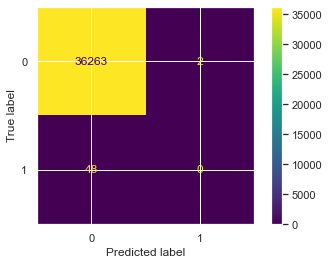

In [161]:
y_predicted = model2.predict(x_cv) > 0.5 # testing on original cv set for valid comparison to previous models
cm = confusion_matrix(y_cv, y_predicted)
dp1 = ConfusionMatrixDisplay(confusion_matrix=cm)
dp1.plot()
print(classification_report(y_cv, y_predicted))
display(f'roc auc score: {roc_auc_score(y_cv, y_predicted)}')

repeating with smaller lambda=0.001 and larger epochs=25, and simpler neural architecture of [128, 64, 32] 3 hidden layers .

In [162]:
l = 0.001
model3 = Sequential() 
model3.add(Dense(128, activation='relu', input_dim=30, kernel_regularizer=tf.keras.regularizers.l2(l=l)))
model3.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=l)))
model3.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=l)))
model3.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(l=l))) 
model3.compile(loss='binary_crossentropy', optimizer='adam',
    metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
) 
model3.summary()

hist3 = model3.fit(x_train_strat, y_train_strat, validation_data=(x_cv, y_cv), epochs=25, batch_size=100)

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_193 (Dense)            (None, 128)               3968      
_________________________________________________________________
dense_194 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_195 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_196 (Dense)            (None, 1)                 33        
Total params: 14,337
Trainable params: 14,337
Non-trainable params: 0
_________________________________________________________________
Train on 205772 samples, validate on 36313 samples
Epoch 1/25
205772/205772 [==============================] - 15s 75us/sample - loss: 85.5368 - auc_40: 0.5011 - precision_40: 0.0024 - recall_40: 0.0085 - val_loss: 103.3591 - val_auc_40: 0.5000 - 

In [ ]:
y_predicted = model3.predict(x_cv) > 0.5 # testing on original cv set for valid comparison to previous models
cm = confusion_matrix(y_cv, y_predicted)
dp1 = ConfusionMatrixDisplay(confusion_matrix=cm)
dp1.plot()
print(classification_report(y_cv, y_predicted))
display(f'roc auc score: {roc_auc_score(y_cv, y_predicted)}')